In [1]:
!pip install -e ../../dictionary_learning

Using runai image conda
Obtaining file:///mnt/dlabscratch1/jminder/repositories/dictionary_learning
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for dictionary_learning (pyproject.toml) ... done
  Created wheel for dictionary_learning: filename=dictionary_learning-0.1.dev294+gde73513-0.editable-py3-none-any.whl size=9888 sha256=1f5d70ce548103f30128e2baa9ab5da53dc77c02f05f83efa3414646bcb12023
  Stored in directory: /tmp/pip-ephem-wheel-cache-dbds1fqb/wheels/a0/da/a2/1cebd3b905ae8fe7b7936ced7745190fe2359dd76b5fcd130a
Successfully built dictionary_learning


In [ ]:
# Run the stage-2-verification.py script
# !python ../../scripts/stage-2-verification.py --n 100000

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import torch as th
import pandas as pd
import numpy as np
from tqdm.auto import tqdm, trange
import json
from dlabutils import model_path

from dictionary_learning import CrossCoder

In [2]:
features_df = pd.read_csv("../results/feature_df.csv")
features_df.head()

,Unnamed: 0,tag,dec_norm_diff,base uselessness score,fw_dead,fw_freq,lmsys_dead,lmsys_freq,freq,dead,avg_activation,lmsys_avg_activation,fw_avg_activation,dec_base_norm,dec_instruct_norm,dec_norm_diff.1,enc_instruct_norm,enc_norm_diff,dec_cos_sim,enc_cos_sim
0,0,Other,0.352013,NaN,False,0.001822,False,0.000676,0.001308,False,3.492434,3.065480,3.621364,0.444054,0.630735,0.352013,1.254812,0.406832,0.951164,0.350836
1,1,Other,0.363011,NaN,False,0.000005,False,0.000133,0.000063,False,15.259659,15.773348,4.781738,0.699583,0.963582,0.363011,1.336623,0.478926,0.789206,0.427605
2,2,Shared,0.484854,NaN,False,0.000134,False,0.000004,0.000075,False,15.845021,2.822504,16.150652,0.978735,1.009308,0.484854,1.014087,0.568982,0.912176,0.526007
3,3,Shared,0.456325,NaN,False,0.000018,False,0.000670,0.000310,False,9.206497,9.398869,3.335491,0.738498,0.809179,0.456325,1.081213,0.549125,0.959958,0.600122
4,4,Shared,0.518658,NaN,False,0.000273,False,0.000024,0.000161,False,12.409294,4.161946,12.998833,0.936113,0.901181,0.518658,0.970215,0.600979,0.937031,0.469657


In [89]:
results = th.load("../results/results_1000000.pt")

In [91]:
results["bucket_relproj"].shape

torch.Size([73728, 10])

In [92]:
relproj_data = results["bucket_relproj"].cpu().numpy()
corre_data_base = results["bucket_correlations"]["base"].cpu().numpy()
corre_data_it = results["bucket_correlations"]["it"].cpu().numpy()
bucket_count = results["bucket_count"].cpu().numpy()
bucket_count.shape

(73728, 10)

In [93]:
N_BUCKETS = relproj_data.shape[1]
N_FEATS = relproj_data.shape[0]
N_FEATS, N_BUCKETS

(73728, 10)

In [94]:
features_df["tag"].unique()

array(['Other', 'Shared', 'IT only', 'Base only'], dtype=object)

In [95]:
features_df.head()

,Unnamed: 0,tag,dec_norm_diff,base uselessness score,fw_dead,fw_freq,lmsys_dead,lmsys_freq,freq,dead,avg_activation,lmsys_avg_activation,fw_avg_activation,dec_base_norm,dec_instruct_norm,dec_norm_diff.1,enc_instruct_norm,enc_norm_diff,dec_cos_sim,enc_cos_sim
0,0,Other,0.352013,NaN,False,0.001822,False,0.000676,0.001308,False,3.492434,3.065480,3.621364,0.444054,0.630735,0.352013,1.254812,0.406832,0.951164,0.350836
1,1,Other,0.363011,NaN,False,0.000005,False,0.000133,0.000063,False,15.259659,15.773348,4.781738,0.699583,0.963582,0.363011,1.336623,0.478926,0.789206,0.427605
2,2,Shared,0.484854,NaN,False,0.000134,False,0.000004,0.000075,False,15.845021,2.822504,16.150652,0.978735,1.009308,0.484854,1.014087,0.568982,0.912176,0.526007
3,3,Shared,0.456325,NaN,False,0.000018,False,0.000670,0.000310,False,9.206497,9.398869,3.335491,0.738498,0.809179,0.456325,1.081213,0.549125,0.959958,0.600122
4,4,Shared,0.518658,NaN,False,0.000273,False,0.000024,0.000161,False,12.409294,4.161946,12.998833,0.936113,0.901181,0.518658,0.970215,0.600979,0.937031,0.469657


In [135]:
it_only_indices = features_df[features_df["tag"] == "IT only"].index
stage1_it_only_indices = features_df[(features_df["tag"] == "IT only") & (features_df["base uselessness score"] > 7.0)].index
shared_indices = features_df[features_df["tag"] == "Shared"].index
base_only_indices = features_df[features_df["tag"] == "Base only"].index
it_only = features_df[features_df["tag"] == "IT only"]
it_only

,Unnamed: 0,tag,dec_norm_diff,base uselessness score,fw_dead,fw_freq,lmsys_dead,lmsys_freq,freq,dead,avg_activation,lmsys_avg_activation,fw_avg_activation,dec_base_norm,dec_instruct_norm,dec_norm_diff.1,enc_instruct_norm,enc_norm_diff,dec_cos_sim,enc_cos_sim
55,55,IT only,0.074728,0.564171,False,0.000488,False,0.001979,0.001157,False,3.202730,3.581563,1.953797,0.101822,0.681284,0.074728,1.557794,0.332738,0.843234,-0.175372
60,60,IT only,0.035816,1.236563,False,0.000045,False,0.001012,0.000479,False,4.266567,4.371139,2.350784,0.059344,0.828444,0.035816,1.604830,0.329540,0.722403,-0.080610
82,82,IT only,0.020163,1.676865,False,0.001617,False,0.001143,0.001405,False,2.677492,2.581585,2.732608,0.028912,0.716964,0.020163,1.516055,0.310337,0.690546,-0.441748
112,112,IT only,0.023094,2.981352,False,0.000089,False,0.002492,0.001167,False,3.459594,3.555409,1.285178,0.039783,0.861325,0.023094,1.675538,0.301523,0.503876,-0.571856
119,119,IT only,0.021084,1.297546,False,0.001157,False,0.002090,0.001575,False,2.417748,2.794493,1.864164,0.028905,0.685456,0.021084,1.515526,0.303074,0.705488,-0.423053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73609,73609,IT only,0.021617,0.121697,False,0.008375,False,0.002793,0.005871,False,1.451566,1.315721,1.488406,0.026693,0.617411,0.021617,1.238191,0.283780,0.800162,-0.463971
73617,73617,IT only,0.055368,8.885779,False,0.000099,False,0.000792,0.000410,False,4.934964,5.324376,2.388831,0.093092,0.840671,0.055368,1.714094,0.300740,0.490673,-0.064851
73637,73637,IT only,0.039172,3.191391,False,0.000040,False,0.000495,0.000244,False,5.244663,5.520833,2.474983,0.071500,0.912634,0.039172,1.790623,0.319846,0.482266,-0.192588
73650,73650,IT only,0.061905,0.439936,False,0.001049,False,0.002605,0.001747,False,2.503193,2.780081,1.943675,0.078565,0.634561,0.061905,1.523299,0.324320,0.734661,-0.255356


In [136]:
stage1_it_only_indices

Index([  771,   883,  1045,  1353,  1742,  2412,  3129,  3746,  3857,  4194,
       ...
       71138, 71200, 71658, 72073, 72097, 72313, 72943, 73200, 73286, 73617],
      dtype='int64', length=180)

In [137]:
def naninfmetric(data, metric="mean"):
    data = np.where(np.isinf(data), 1e10, data)
    if metric == "mean":
        return np.nanmean(data, axis=0)
    elif metric == "median":
        return np.nanmedian(data, axis=0)
    else:
        raise ValueError(f"Invalid metric: {metric}")

In [144]:
import plotly.graph_objects as go
import numpy as np
METRIC = "median"
SHOW_STD = False # Added bool to control std areas

# Create figure
fig = go.Figure()

# Plot individual IT only feature lines
# for idx in it_only_indices:
#     feature_data = relproj_data[idx]
#     fig.add_trace(go.Scatter(
#         x=[f"{i}0%-{i+1}0%" for i in range(0, 10)],
#         y=feature_data,
#         mode='lines',
#         line=dict(color='rgba(0,0,255,0.1)'),
#         showlegend=False
#     ))

# Add mean lines and variance for IT Only Stage 0
mean_data = naninfmetric(relproj_data[it_only_indices], metric=METRIC)
std_data = np.nanstd(relproj_data[it_only_indices], axis=0)
x = [f"{i}0%-{i+1}0%" for i in range(0, 10)]
if SHOW_STD:
    fig.add_trace(go.Scatter(
        x=x,
        y=mean_data + std_data,
        mode='lines',
        line=dict(width=0),
        showlegend=False,
        name='Upper Bound'
    ))
    fig.add_trace(go.Scatter(
        x=x,
        y=mean_data - std_data,
        mode='lines',
        line=dict(width=0),
        fillcolor='rgba(255,0,0,0.2)',
        fill='tonexty',
        showlegend=False,
        name='Lower Bound'
    ))
fig.add_trace(go.Scatter(
    x=x,
    y=mean_data,
    mode='lines',
    line=dict(color='red', width=2),
    name=f'Stage 0 IT Only {METRIC}'
))

# Add mean lines and variance for IT Only Stage 1
mean_data = naninfmetric(relproj_data[stage1_it_only_indices], metric=METRIC)
std_data = np.nanstd(relproj_data[stage1_it_only_indices], axis=0)
if SHOW_STD:
    fig.add_trace(go.Scatter(
        x=x,
        y=mean_data + std_data,
        mode='lines',
        line=dict(width=0),
        showlegend=False
    ))
    fig.add_trace(go.Scatter(
        x=x,
        y=mean_data - std_data,
        mode='lines',
        line=dict(width=0),
        fillcolor='rgba(240,128,128,0.2)',
        fill='tonexty',
        showlegend=False
    ))
fig.add_trace(go.Scatter(
    x=x,
    y=mean_data,
    mode='lines',
    line=dict(color='lightcoral', width=2),
    name=f'Stage 1 IT Only {METRIC}'
))

# Add mean lines and variance for Shared
mean_data = naninfmetric(relproj_data[shared_indices], metric=METRIC)
std_data = np.nanstd(relproj_data[shared_indices], axis=0)
if SHOW_STD:
    fig.add_trace(go.Scatter(
        x=x,
        y=mean_data + std_data,
        mode='lines',
        line=dict(width=0),
        showlegend=False
    ))
    fig.add_trace(go.Scatter(
        x=x,
        y=mean_data - std_data,
        mode='lines',
        line=dict(width=0),
        fillcolor='rgba(0,255,0,0.2)',
        fill='tonexty',
        showlegend=False
    ))
fig.add_trace(go.Scatter(
    x=x,
    y=mean_data,
    mode='lines', 
    line=dict(color='green', width=2),
    name=f'Shared {METRIC}'
))

# Add mean lines and variance for Base Only
mean_data = naninfmetric(relproj_data[base_only_indices], metric=METRIC)
std_data = np.nanstd(relproj_data[base_only_indices], axis=0)
if SHOW_STD:
    fig.add_trace(go.Scatter(
        x=x,
        y=mean_data + std_data,
        mode='lines',
        line=dict(width=0),
        showlegend=False
    ))
    fig.add_trace(go.Scatter(
        x=x,
        y=mean_data - std_data,
        mode='lines',
        line=dict(width=0),
        fillcolor='rgba(0,0,255,0.2)',
        fill='tonexty',
        showlegend=False
    ))
fig.add_trace(go.Scatter(
    x=x,
    y=mean_data,
    mode='lines',
    line=dict(color='blue', width=2),
    name=f'Base Only {METRIC}'
))

# Update layout
fig.update_layout(
    title='Features: Relative Projections Across Activation Buckets',
    xaxis_title='Activation Buckets (relative per feature)',
    yaxis_title='Relative Projection',
    yaxis=dict(range=[0, 1.1]),
    template='plotly_white',
    width=1000,
    height=500,
    showlegend=True,
    legend=dict(
        yanchor="top",
        y=0.3,
        xanchor="right",
        x=0.99
    )
)

fig.show()
fig.write_image("../plots/relative_projections_means.png")

In [141]:
data = relproj_data[base_only_indices][:, 4]
mean_val = np.nanmean(data)

fig = go.Figure()

# Add violin plot
fig.add_trace(go.Violin(
    y=data,
    box_visible=True,
    line_color='blue',
    meanline_visible=True,
    fillcolor='lightblue',
    opacity=0.6,
    name='Distribution'
))

# # Add individual points
# fig.add_trace(go.Scatter(
#     y=data,
#     mode='markers',
#     marker=dict(
#         color='blue',
#         size=3,
#         opacity=0.3
#     ),
#     name='Individual Points'
# ))

# Update layout
fig.update_layout(
    title='Distribution of Base Only Features - Bucket 4',
    yaxis_title='Relative Projection Value',
    showlegend=True,
    width=800,
    height=500,
    template='plotly_white'
)

fig.show()

In [143]:
import plotly.graph_objects as go
import numpy as np
METRIC = "median"
# Create figure
fig = go.Figure()

# Plot individual IT only feature lines
# for idx in it_only_indices:
#     feature_data = relproj_data[idx]
#     fig.add_trace(go.Scatter(
#         x=[f"{i}0%-{i+1}0%" for i in range(0, 10)],
#         y=feature_data,
#         mode='lines',
#         line=dict(color='rgba(0,0,255,0.1)'),
#         showlegend=False
#     ))

# Add mean lines
mean_data = naninfmetric(bucket_count[it_only_indices], metric=METRIC)
fig.add_trace(go.Scatter(
    x=[f"{i}0%-{i+1}0%" for i in range(0, 10)],
    y=mean_data,
    mode='lines',
    line=dict(color='red', width=2),
    name=f'Stage 0 IT Only {METRIC}'
))

# Add mean lines
mean_data = naninfmetric(bucket_count[stage1_it_only_indices], metric=METRIC)
fig.add_trace(go.Scatter(
    x=[f"{i}0%-{i+1}0%" for i in range(0, 10)],
    y=mean_data,
    mode='lines',
    line=dict(color='lightcoral', width=2),
    name=f'Stage 1 IT Only {METRIC}'
))


mean_data = naninfmetric(bucket_count[shared_indices], metric=METRIC)
fig.add_trace(go.Scatter(
    x=[f"{i}0%-{i+1}0%" for i in range(0, 10)],
    y=mean_data,
    mode='lines', 
    line=dict(color='green', width=2),
    name=f'Shared {METRIC}'
))

mean_data = naninfmetric(bucket_count[base_only_indices], metric=METRIC)
fig.add_trace(go.Scatter(
    x=[f"{i}0%-{i+1}0%" for i in range(0, 10)],
    y=mean_data,
    mode='lines',
    line=dict(color='blue', width=2),
    name=f'Base Only {METRIC}'
))

# Update layout
fig.update_layout(
    title='Features: Mean Activation Count Across Activation Buckets',
    xaxis_title='Activation Buckets (relative per feature)',
    yaxis_title='Activation Count',
    template='plotly_white',
    width=1000,
    height=500,
    showlegend=True,
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="right",
        x=0.99
    ),
    xaxis=dict(range=[1, 10]),
    yaxis=dict(
        type='log',
        range=[0, 3] # log10 of 1000
    ),
)

fig.show()
fig.write_image(f"../plots/activation_counts_{METRIC}_{N_BUCKETS}.png")

In [155]:
last_k = 6
cut_off_k = 2
it_only_focus = stage1_it_only_indices
# Get relative projections for IT only features in the last bucket
last_bucket_projections = relproj_data[it_only_focus, -last_k:-cut_off_k]

# Find indices of features with high relative projection in last bucket
low_proj_indices = it_only_focus[(last_bucket_projections < 0.4).sum(axis=1) > last_k-1-cut_off_k]

print(f"Found {len(low_proj_indices)} IT only features with low (<0.1) relative projection in last bucket")
print("\nFeature indices:", low_proj_indices)

# Create figure
fig = go.Figure()

# Plot each feature
for idx in low_proj_indices:
    feature_data = relproj_data[idx]
    fig.add_trace(go.Scatter(
        x=[f"{i}0%-{i+1}0%" for i in range(0, 10)],
        y=feature_data,
        mode='lines',
        name=f'Feature {idx}',
        opacity=0.5
    ))

# Update layout
fig.update_layout(
    title='IT Only Features with Low Relative Projection (<0.3) in above 50 buckets',
    xaxis_title='Activation Buckets',
    yaxis_title='Relative Projection',
    template='plotly_white',
    width=1000,
    height=500,
    showlegend=True,
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="right", 
        x=1.15
    )
)
fig.write_image(f"../plots/relative_projections_low_{last_k}_{cut_off_k}.png")
fig.show()

Found 22 IT only features with low (<0.1) relative projection in last bucket

Feature indices: Index([ 5406, 11412, 15338, 16143, 21760, 28876, 38337, 38853, 44461, 47053,
       48755, 51823, 53547, 53904, 55432, 57717, 59988, 68066, 68510, 69810,
       72073, 73286],
      dtype='int64')


In [160]:
relproj_data[26281]

array([1.2796475 , 0.11722401, 0.09947231, 0.06115308, 0.14043003,
       0.43543127, 0.32641426, 0.15138058, 0.23093335, 0.55728865],
      dtype=float32)

In [ ]:
last_k = 6
cut_off_k = 2
it_only_focus = stage1_it_only_indices
# Get relative projections for IT only features in the last bucket
last_bucket_projections = relproj_data[it_only_focus, -last_k:-cut_off_k]

# Find indices of features with high relative projection in last bucket
low_proj_indices = it_only_focus[(last_bucket_projections < 0.3).sum(axis=1) > last_k-1-cut_off_k]

print(f"Found {len(low_proj_indices)} IT only features with low (<0.1) relative projection in last bucket")
print("\nFeature indices:", low_proj_indices)

# Create figure
fig = go.Figure()

# Plot each feature
for idx in low_proj_indices:
    feature_data = relproj_data[idx]
    fig.add_trace(go.Scatter(
        x=[f"{i}0%-{i+1}0%" for i in range(0, 10)],
        y=feature_data,
        mode='lines',
        name=f'Feature {idx}',
        opacity=0.5
    ))

# Update layout
fig.update_layout(
    title='IT Only Features with Low Relative Projection (<0.1) in above 50 buckets',
    xaxis_title='Activation Buckets',
    yaxis_title='Relative Projection',
    template='plotly_white',
    width=1000,
    height=500,
    showlegend=True,
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="right", 
        x=1.15
    )
)
fig.write_image(f"../plots/relative_projections_low_{last_k}_{cut_off_k}.png")
fig.show()

In [152]:
last_k = 6
cut_off_k = 2
it_only_focus = stage1_it_only_indices
# Get relative projections for IT only features in the last bucket
last_bucket_projections = relproj_data[it_only_focus, -last_k:-cut_off_k]

# Find indices of features with high relative projection in last bucket
high_proj_indices = it_only_focus[(last_bucket_projections > 0.6).sum(axis=1) > last_k-1-cut_off_k]

print(f"Found {len(high_proj_indices)} IT only features with high (>0.8) relative projection in last bucket")
print("\nFeature indices:", high_proj_indices)

# Create figure
fig = go.Figure()

# Plot each feature
for idx in high_proj_indices:
    feature_data = relproj_data[idx]
    fig.add_trace(go.Scatter(
        x=[f"{i}0%-{i+1}0%" for i in range(0, 10)],
        y=feature_data,
        mode='lines',
        name=f'Feature {idx}',
        opacity=0.5
    ))

# Update layout
fig.update_layout(
    title='IT Only Features with High Relative Projection',
    xaxis_title='Activation Percentile Buckets',
    yaxis_title='Relative Projection',
    template='plotly_white',
    width=1000,
    height=500,
    showlegend=True,
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="right",
        x=1.15
    )
)

fig.show()
fig.write_image(f"../plots/relative_projections_high_{last_k}_{cut_off_k}.png")


Found 9 IT only features with high (>0.8) relative projection in last bucket

Feature indices: Index([9472, 13865, 16908, 18104, 36954, 42157, 42351, 43261, 70657], dtype='int64')


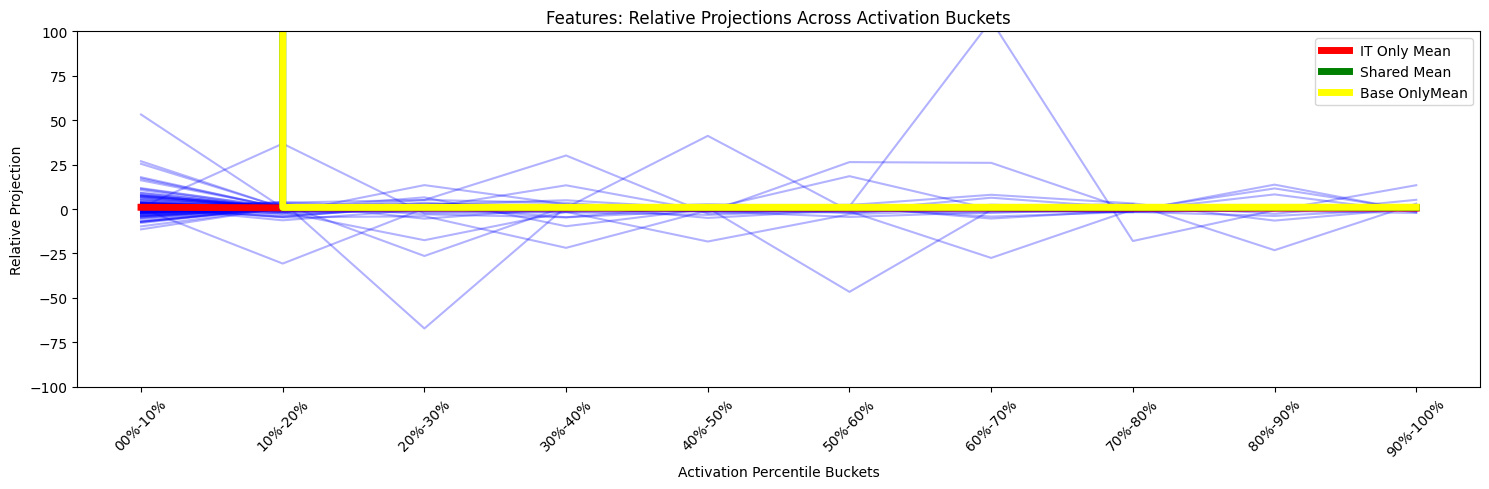

In [110]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create figure with appropriate size
plt.figure(figsize=(15, 5))

# Plot one line per IT only feature
for idx in it_only_indices:
    feature_data = relproj_data[idx]
    plt.plot(range(N_BUCKETS), feature_data, alpha=0.3, color='blue')

# Calculate and plot mean line
mean_data = naninfmean(relproj_data[it_only_indices])
plt.plot(range(N_BUCKETS), mean_data, color='red', linewidth=5, label='IT Only Mean')

# Calculate and plot mean line of shared features
mean_data = naninfmean(relproj_data[shared_indices])
plt.plot(range(N_BUCKETS), mean_data, color='green', linewidth=5, label='Shared Mean')

# Calculate and plot mean line
mean_data = naninfmean(relproj_data[base_only_indices])
plt.plot(range(N_BUCKETS), mean_data, color='yellow', linewidth=5, label='Base OnlyMean')

# Add labels
plt.xlabel('Activation Percentile Buckets')
plt.ylabel('Relative Projection')
plt.title('Features: Relative Projections Across Activation Buckets')
plt.xticks(range(N_BUCKETS), [f"{i}0%-{i+1}0%" for i in range(0, 10)], rotation=45)
plt.ylim(-100, 100)  # Set y-axis limits
plt.legend()

plt.tight_layout()
plt.show()

In [138]:
stage1_it_only_indices = features_df[(features_df["tag"] == "IT only") & (features_df["base uselessness score"] > 5)].index
stage1_it_only_indices


Index([  465,   771,   883,  1045,  1353,  1547,  1742,  2412,  3033,  3129,
       ...
       72313, 72438, 72517, 72627, 72819, 72943, 72959, 73200, 73286, 73617],
      dtype='int64', length=288)

In [60]:
stage2_it_only_indices = stage1_it_only_indices[np.nanmax(corre_data_base[stage1_it_only_indices][:, -6:], axis=1) < 0.0]
stage2_it_only_indices

/tmp/ipykernel_141485/348078002.py:1: RuntimeWarning:

All-NaN slice encountered



Index([62118, 66030], dtype='int64')

/tmp/ipykernel_141485/3621348661.py:3: RuntimeWarning:

Mean of empty slice



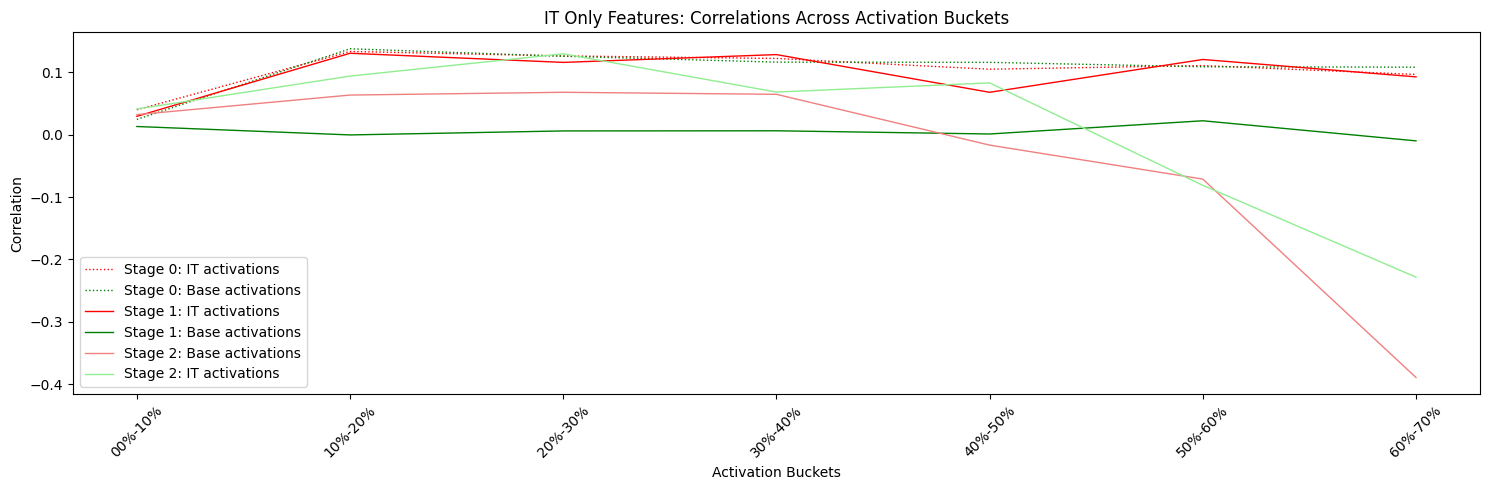

<Figure size 640x480 with 0 Axes>

In [159]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

MAX_BUCKETS = 7
# Create figure with appropriate size
plt.figure(figsize=(15, 5))

# Calculate and plot mean line
mean_data = naninfmean(corre_data_it[it_only_indices])
plt.plot(range(MAX_BUCKETS), mean_data[:MAX_BUCKETS], color='red', linewidth=1, linestyle=':', label='Stage 0: IT activations')

# Calculate and plot mean line of shared features
mean_data = naninfmean(corre_data_base[shared_indices])
plt.plot(range(MAX_BUCKETS), mean_data[:MAX_BUCKETS], color='green', linewidth=1, linestyle=':', label='Stage 0: Base activations')


# Calculate and plot mean line
mean_data = naninfmean(corre_data_it[stage1_it_only_indices])
plt.plot(range(MAX_BUCKETS), mean_data[:MAX_BUCKETS], color='red', linewidth=1, label='Stage 1: IT activations')

# Calculate and plot mean line
mean_data = naninfmean(corre_data_base[stage1_it_only_indices])
plt.plot(range(MAX_BUCKETS), mean_data[:MAX_BUCKETS], color='green', linewidth=1, label='Stage 1: Base activations')

# Calculate and plot mean line
mean_data = naninfmean(corre_data_base[stage2_it_only_indices])
plt.plot(range(MAX_BUCKETS), mean_data[:MAX_BUCKETS], color='lightcoral', linewidth=1, label='Stage 2: Base activations')

mean_data = naninfmean(corre_data_it[stage2_it_only_indices])
plt.plot(range(MAX_BUCKETS), mean_data[:MAX_BUCKETS], color='lightgreen', linewidth=1, label='Stage 2: IT activations')

# Add labels
plt.xlabel('Activation Buckets')
plt.ylabel('Correlation')
plt.title('IT Only Features: Correlations Across Activation Buckets')
plt.xticks(range(MAX_BUCKETS), [f"{i}0%-{i+1}0%" for i in range(0, 7)], rotation=45)
plt.legend()

plt.tight_layout()
plt.show()
# save
plt.savefig("../plots/feature_correlations.png")

In [78]:
corre_data_base, corre_data_it

(array([[ 0.05369774,  0.11310016,  0.14313278, ..., -0.44209132,
                 nan,         nan],
        [ 0.00987954,  0.20359589,  0.6006663 , ...,         nan,
                 nan,         nan],
        [ 0.00625209,  0.0390608 ,  0.2981518 , ...,  0.6362908 ,
                 nan, -1.        ],
        ...,
        [ 0.00566619, -0.04946877,  0.16287498, ...,  0.5042869 ,
          0.23374172,  0.38300377],
        [ 0.01413342, -0.22325377, -0.2008539 , ...,         nan,
         -1.        ,         nan],
        [ 0.01092592,  0.36414796,  0.28013095, ..., -0.06396029,
          1.        ,         nan]], dtype=float32),
 array([[ 0.05243141,  0.1256091 ,  0.17679846, ..., -0.6344021 ,
                 nan,         nan],
        [ 0.01267037,  0.44353867,  0.6638929 , ...,         nan,
                 nan,         nan],
        [ 0.00585828,  0.05850691,  0.32402983, ...,  0.76964766,
                 nan, -1.        ],
        ...,
        [ 0.00461256,  0.01236078,  0.4

In [82]:
rel_corre = corre_data_base/corre_data_it

Found 17 features with high correlation in later buckets


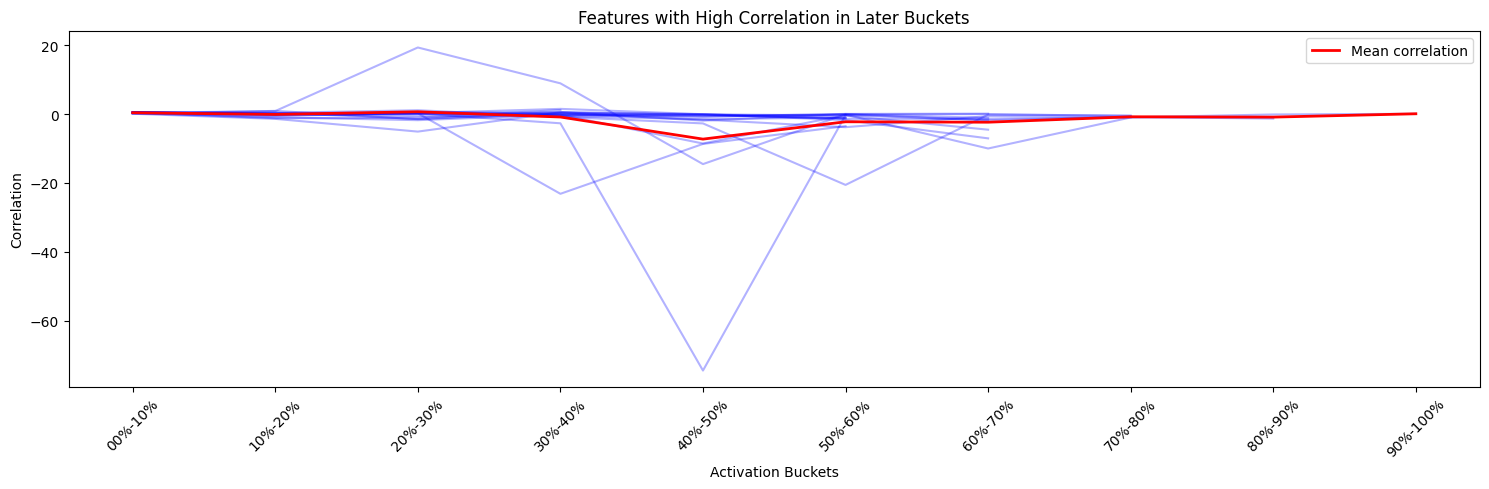

Index([ 4661,  5406,  6096, 11055, 16557, 28558, 31196, 31726, 37409, 40844,
       42587, 48345, 48767, 57637, 59988, 64612, 72943],
      dtype='int64')

In [153]:
# Find IT only features with high correlation in later buckets (last 5 buckets)
focus_indices = stage1_it_only_indices
high_corr_indices = stage1_it_only_indices[np.nanmax(rel_corre[stage1_it_only_indices][:, -6:], axis=1) < 0.3]
print(f"Found {len(high_corr_indices)} features with high correlation in later buckets")

# Plot correlations for these features
plt.figure(figsize=(15, 5))

# Plot individual feature correlations
for idx in high_corr_indices:
    plt.plot(range(10), rel_corre[idx], alpha=0.3, color='blue')
    
# Plot mean correlation
mean_corr = naninfmean(rel_corre[high_corr_indices])
plt.plot(range(10), mean_corr, color='red', linewidth=2, label='Mean correlation')

plt.xlabel('Activation Buckets')
plt.ylabel('Correlation') 
plt.title('Features with High Correlation in Later Buckets')
plt.xticks(range(10), [f"{i}0%-{i+1}0%" for i in range(0, 10)], rotation=45)
plt.legend()

plt.tight_layout()
plt.show()
high_corr_indices

In [106]:
stage2_it_only_indices = stage1_it_only_indices[np.abs(np.nanmax(corre_data_base[stage1_it_only_indices][:, -6:], axis=1)) < 0.05]
stage2_it_only_indices

/tmp/ipykernel_141485/2325822930.py:1: RuntimeWarning:

All-NaN slice encountered



Index([6573, 28107, 30257, 30282, 47785, 50194, 61256, 62118, 66030, 69121], dtype='int64')

In [107]:
features_df.loc[stage2_it_only_indices]

,Unnamed: 0,tag,dec_norm_diff,base uselessness score,fw_dead,fw_freq,lmsys_dead,lmsys_freq,freq,dead,avg_activation,lmsys_avg_activation,fw_avg_activation,dec_base_norm,dec_instruct_norm,dec_norm_diff.1,enc_instruct_norm,enc_norm_diff,dec_cos_sim,enc_cos_sim
6573,6573,IT only,0.021687,0.418300,False,0.006184,False,0.003779,0.005105,False,1.549849,1.820225,1.415488,0.025681,0.592092,0.021687,1.328596,0.291929,0.777348,-0.448483
28107,28107,IT only,0.029529,0.433512,False,0.003007,False,0.002900,0.002959,False,1.541543,1.534646,1.546954,0.033437,0.566170,0.029529,1.670087,0.229553,0.846296,-0.338007
30257,30257,IT only,0.018443,0.177384,False,0.005999,False,0.004461,0.005309,False,1.523861,1.607106,1.473516,0.021308,0.577670,0.018443,1.472819,0.246046,0.785931,-0.285568
30282,30282,IT only,0.083278,0.387698,False,0.000793,False,0.001005,0.000888,False,3.768305,4.061713,3.466022,0.141142,0.847421,0.083278,1.288793,0.273171,0.910181,-0.114625
47785,47785,IT only,0.023032,0.343355,False,0.008200,False,0.003637,0.006154,False,1.455213,1.349548,1.493328,0.026951,0.585070,0.023032,1.363049,0.240307,0.842013,-0.437924
50194,50194,IT only,0.040444,0.473485,False,0.008314,False,0.002499,0.005706,False,2.043869,1.782527,2.107760,0.054632,0.675405,0.040444,1.452770,0.308710,0.859633,-0.357146
61256,61256,IT only,0.045635,0.335513,False,0.001092,False,0.001443,0.001249,False,2.500252,2.788457,2.190607,0.067924,0.744215,0.045635,1.429911,0.263491,0.869656,-0.311577
62118,62118,IT only,0.048508,0.264237,False,0.000721,False,0.002780,0.001645,False,2.335682,2.466370,1.925904,0.064111,0.660831,0.048508,1.639057,0.256950,0.862455,-0.295498
66030,66030,IT only,0.079421,-0.058537,False,0.003204,False,0.002348,0.002820,False,1.594870,1.519187,1.639983,0.085707,0.539576,0.079421,1.477431,0.243923,0.930529,-0.074965
69121,69121,IT only,0.032658,0.166980,False,0.003635,False,0.003979,0.003789,False,1.592126,1.632792,1.555923,0.036792,0.563287,0.032658,1.574248,0.240073,0.871056,-0.367297


In [77]:
mean_data = np.nanmean(relproj_data[shared_indices], axis=0)
mean_data.shape

(10,)

In [78]:
mean_data[0]

np.float32(inf)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create figure with appropriate size
plt.figure(figsize=(15, 10))

# Plot one line per IT only feature
for idx in it_only_indices:
    feature_data = corre_data_it[idx]
    plt.plot(range(N_BUCKETS), feature_data, alpha=0.3, color='blue')

# Calculate and plot mean line
mean_data = np.nanmean(relproj_data[it_only_indices], axis=0)
plt.plot(range(N_BUCKETS), mean_data, color='red', linewidth=2, label='Mean')

# Add labels
plt.xlabel('Activation Percentile Buckets')
plt.ylabel('Relative Projection')
plt.title('IT Only Features: Relative Projections Across Activation Buckets')
plt.xticks(range(N_BUCKETS), [f"{i}0%-{i+1}0%" for i in range(0, 10)], rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create figure with appropriate size
plt.figure(figsize=(15, 10))

# Plot one line per IT only feature
for idx in it_only_indices:
    feature_data = relproj_data[idx]
    plt.plot(range(N_BUCKETS), feature_data, alpha=0.3, color='blue')

# Calculate and plot mean line
mean_data = np.nanmean(relproj_data[it_only_indices], axis=0)
plt.plot(range(N_BUCKETS), mean_data, color='red', linewidth=2, label='Mean')

# Add labels
plt.xlabel('Activation Percentile Buckets')
plt.ylabel('Relative Projection')
plt.title('IT Only Features: Relative Projections Across Activation Buckets')
plt.xticks(range(N_BUCKETS), [f"{i}0%-{i+1}0%" for i in range(0, 10)], rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Convert to numpy and replace nans with 0
heatmap_data = data[37785:37785+2, :]
data_it = 
# Create figure with appropriate size
plt.figure(figsize=(15, 10))

# Create heatmap with mask for nan values
sns.heatmap(heatmap_data, 
            cmap='viridis',  # You can change the colormap as needed
            xticklabels=[f"{i}0%-{i+1}0%" for i in range(0, 10)],  # Start x-axis labels from start_percentile, show every 20th
            yticklabels=False,  # Don't show y-axis labels as there are too many features
            cbar_kws={'label': 'Relative Projection'},
            mask=np.isnan(heatmap_data))  # This will make NaN values appear white


# Add labels
plt.xlabel('Activation Percentile Buckets')
plt.ylabel('Features')
plt.title('Feature Relative Projections Across Activation Buckets')

plt.tight_layout()
plt.show()

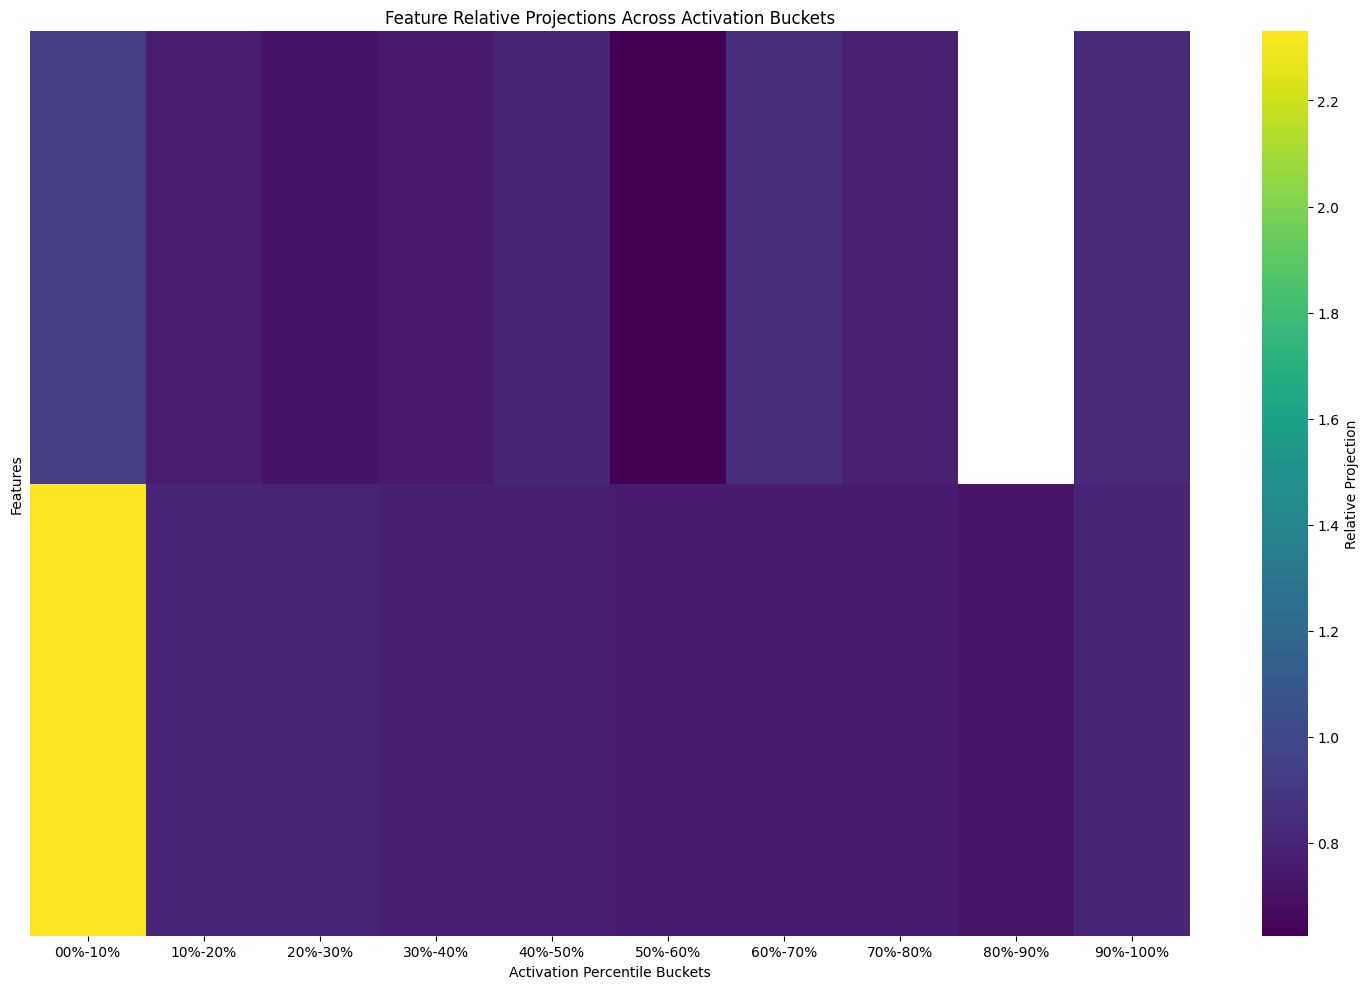

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Convert to numpy and replace nans with 0
heatmap_data = data[37785:37785+2, :]
data_it = 
# Create figure with appropriate size
plt.figure(figsize=(15, 10))

# Create heatmap with mask for nan values
sns.heatmap(heatmap_data, 
            cmap='viridis',  # You can change the colormap as needed
            xticklabels=[f"{i}0%-{i+1}0%" for i in range(0, 10)],  # Start x-axis labels from start_percentile, show every 20th
            yticklabels=False,  # Don't show y-axis labels as there are too many features
            cbar_kws={'label': 'Relative Projection'},
            mask=np.isnan(heatmap_data))  # This will make NaN values appear white


# Add labels
plt.xlabel('Activation Percentile Buckets')
plt.ylabel('Features')
plt.title('Feature Relative Projections Across Activation Buckets')

plt.tight_layout()
plt.show()

In [18]:
corre_data = results["bucket_correlations"]["base"].cpu().numpy()

In [25]:
results.keys()

dict_keys(['correlations', 'bucket_correlations', 'relproj', 'bucket_relproj'])

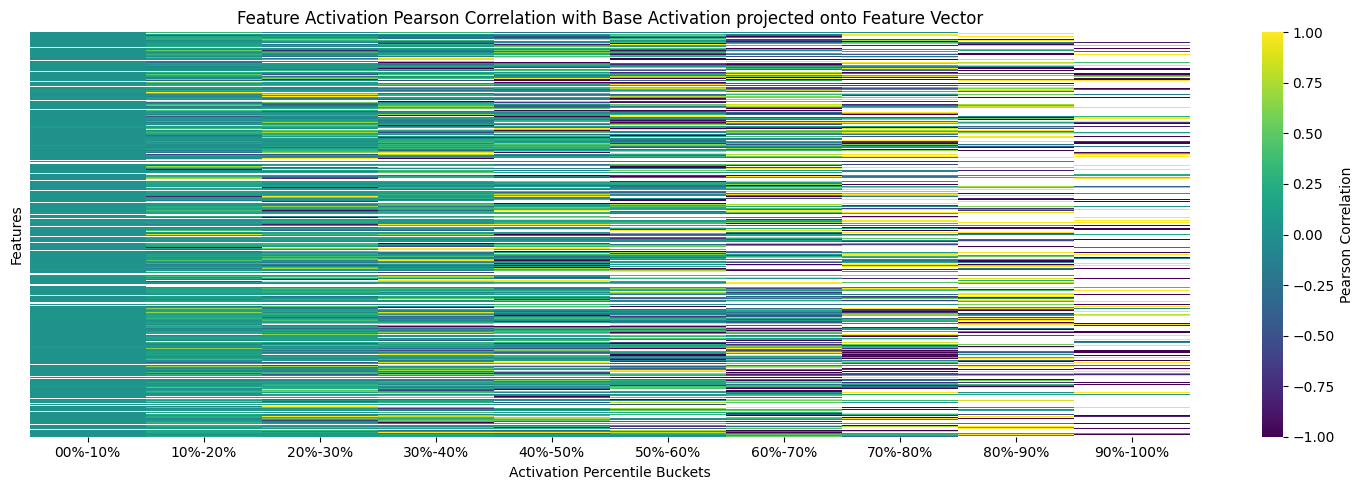

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

start_percentile = 10
# Convert to numpy and replace nans with 0
heatmap_data = corre_data[:, :]

# Create figure with appropriate size
plt.figure(figsize=(15, 5))

# Create heatmap with mask for nan values
sns.heatmap(heatmap_data, 
            cmap='viridis',  # You can change the colormap as needed
            xticklabels=[f"{i}0%-{i+1}0%" for i in range(0, 10)],  # Start x-axis labels from start_percentile, show every 20th
            yticklabels=False,  # Don't show y-axis labels as there are too many features
            cbar_kws={'label': 'Pearson Correlation'},
            mask=np.isnan(heatmap_data))  # This will make NaN values appear white


# Add labels
plt.xlabel('Activation Percentile Buckets')
plt.ylabel('Features')
plt.title('Feature Activation Pearson Correlation with Base Activation projected onto Feature Vector')

plt.tight_layout()
plt.show()